In [ ]:
#imported libs
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import get_file
import os
from sklearn.preprocessing import StandardScaler


In [2]:
#dataset_dir  = r"E:\APPS\PythonDataSets\caltech\caltech-101\101_ObjectCategories\101_ObjectCategories"
dataset_dir = r"E:\APPS\PythonDataSets\caltech\caltech-101\101_ObjectCategories\filtered_preprocessed_categories"



# Parameters
batch_size = 32
image_size = (64, 128)

# Load the training and validation datasets
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=image_size,
    batch_size=batch_size
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=image_size,
    batch_size=batch_size
)


def dataset_to_numpy(dataset):
    """
    Convert a tf.data.Dataset into NumPy arrays for features and labels.
    Args:
        dataset: A tf.data.Dataset object.
    Returns:
        X: Numpy array of features (images).
        y: Numpy array of labels.
    """
    X = []
    y = []
    for images, labels in dataset:
        X.append(images.numpy())
        y.append(labels.numpy())
    return np.concatenate(X, axis=0), np.concatenate(y, axis=0)

# Convert the train and validation datasets to NumPy arrays
X_train, y_train = dataset_to_numpy(train_dataset)
X_test, y_test = dataset_to_numpy(val_dataset)

X_test =[cv2.resize(img.astype(np.uint8), (64, 128)) for img in X_test]
X_train=[cv2.resize(img.astype(np.uint8), (64, 128)) for img in X_train]

Found 9145 files belonging to 101 classes.
Using 7316 files for training.
Found 9145 files belonging to 101 classes.
Using 1829 files for validation.


In [ ]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

In [3]:
#Accuracy
def accuracy(y_test1, y_pred1):
    y_pred1 = np.array(y_pred1)
    counter = 0
    for i in range(len(y_pred1)):
      if (y_pred1[i] == y_test1[i]):
        counter += 1
    accuracy = counter / len(y_pred1)
    accuracy *= 100
    return accuracy
  


In [4]:
# visualizing the results
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def visualize_results(y_test,y_predict):
    class_names = [folder for folder in os.listdir(r"E:\APPS\PythonDataSets\caltech\caltech-101\101_ObjectCategories\filtered_preprocessed_categories") if os.path.isdir(os.path.join(r"E:\APPS\PythonDataSets\caltech\caltech-101\101_ObjectCategories\filtered_preprocessed_categories", folder))]
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_predict)

    # Calculate accuracy for each class
    class_accuracies = (cm.diagonal() / cm.sum(axis=1)) * 100

    # Display class-wise accuracy
    #classes = [f"Class {i}" for i in range(len(class_accuracies))]  # Replace with actual class names if available

    # Plot the accuracies
    plt.figure(figsize=(15, 5))
    plt.bar(class_names, class_accuracies, color='skyblue')
    plt.xlabel("Classes")
    plt.ylabel("Accuracy (%)")
    plt.title("Class-Wise Accuracy")
    plt.xticks(rotation=90)
    plt.ylim(0, 100)  # Accuracy is in percentage
    plt.tight_layout()
    plt.show()

    # Print the class-wise accuracy
    #for i, accuracy in enumerate(class_accuracies):
        #print(f"Accuracy for {class_names[i]}: {accuracy:.2f}%")




In [16]:
#Color Histogran Extraction def
def extract_color_histogram(image, bins=(8, 8, 8)):
    """
    Extract a 3D color histogram from an RGB image.
    Args:
        image (numpy array): Input image in RGB format.
        bins (tuple): Number of bins for each channel (R, G, B).
    Returns:
        numpy array: Flattened color histogram feature vector.
    """
    # Calculate the 3D histogram for the HSV channels
    hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    #print(hist.shape)
    # Normalize the histogram to ensure invariance to lighting changes
    
    #hist = cv2.normalize(hist, hist).flatten()
    

    return hist.flatten()

In [7]:
#HOG def
def extract_hog_features(image):
    # HOG parameters
    winSize = (64, 128)
    blockSize = (16, 16)
    blockStride = (8, 8)
    cellSize = (8, 8)
    nbins = 9
    
    hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins)
    hog_features = hog.compute(image)
     
    return hog_features

In [40]:
#LBP def
from skimage.feature import local_binary_pattern

def extract_lbp_features(image, num_points=32, radius=8):
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    grid_size = (8, 8)  # Divide image into a 8x8 grid for histograms
     # Compute LBP
    lbp = local_binary_pattern(gray_img, num_points, radius, method="uniform")
    h, w = lbp.shape
    
    # Divide the image into grids and compute histograms
    grid_h, grid_w = h // grid_size[0], w // grid_size[1]
    histograms = []
    
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            grid = lbp[i * grid_h:(i + 1) * grid_h, j * grid_w:(j + 1) * grid_w]
            hist, _ = np.histogram(grid, bins=np.arange(0, num_points + 3), density=True)
            histograms.append(hist)
    
    # Concatenate histograms
    return np.concatenate(histograms)
    """gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray_img, num_points, radius, method='uniform')
     # Calculate the histogram of LBP
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, num_points + 3), range=(0, num_points + 2))
       

    return np.array(hist)"""

In [ ]:
# Step 1: Extract LBP features for train and test
lbp_features_train = np.array([extract_lbp_features(image) for image in  X_train])
lbp_features_test  = np.array([extract_lbp_features(image) for image in X_test])

In [ ]:
# Step 2: Extract HOG features for train and test
hog_features_train = np.array([extract_hog_features(image) for image in X_train])
hog_features_test  = np.array([extract_hog_features(image) for image in X_test])
# scaling the features
scaler = StandardScaler()
hog_features_train = scaler.fit_transform(hog_features_train)
hog_features_test = scaler.transform(hog_features_test)

In [20]:
# Step 3: Extract Color Histogram features for train and test
clhg_features_train = np.array([extract_color_histogram(image) for image in X_train])
clhg_features_test  = np.array([extract_color_histogram(image) for image in X_test])
#scaling the features
scaler3 = StandardScaler()
clhg_features_train = scaler3.fit_transform(clhg_features_train)
clhg_features_test = scaler3.transform(clhg_features_test)

In [10]:
import numpy as np

class KNNClassifier:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def weighted_vote(self, labels, distances):
        # Create a dictionary to store the weighted scores for each label
        label_scores = {}
        for label, distance in zip(labels, distances):
            # Use 1/distance as the weight to favor closer neighbors
            weight = 1 / (distance + 1e-6)  # Add a small value to avoid division by zero
            if label in label_scores:
                label_scores[label] += weight
            else:
                label_scores[label] = weight

        # Return the label with the highest score
        return max(label_scores, key=label_scores.get)

    def predict(self, image_test):
        # Compute distances to all training samples
        distances = np.linalg.norm(self.X_train - image_test.reshape(1, -1), axis=1)

        # Get indices of the k nearest neighbors
        k_nearest = np.argsort(distances)[:self.k]

        # Get the labels and distances of the k nearest neighbors
        k_nearest_labels = self.y_train[k_nearest]
        k_nearest_distances = distances[k_nearest]

        # Predict based on weighted vote
        prediction = self.weighted_vote(k_nearest_labels, k_nearest_distances)

        return prediction


In [ ]:
#compare with pre-built KNN from sklearn

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(clhg_features_train, y_train)
predictions = knn.predict(clhg_features_test)
accuracy(y_test, predictions)


In [ ]:
model = KNNClassifier(9)
model.fit(lbp_features_train,y_train)

y_pred = np.array([model.predict( i.reshape(1, -1)) for i in  lbp_features_test])

In [ ]:
print(accuracy(y_test, y_pred))
visualize_results(y_test, y_pred)

In [11]:
model2 = KNNClassifier(5)
model2.fit(hog_features_train,y_train)

y_pred2 = np.array([model2.predict( i.reshape(1, -1)) for i in  hog_features_test])

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
hog = cv2.HOGDescriptor()

# Extract HOG features
X = [hog.compute(cv2.resize(img.astype(np.uint8) if img.dtype != np.uint8 else img, (64, 128))).flatten() for img in X_train]
XX= [hog.compute(cv2.resize(img.astype(np.uint8) if img.dtype != np.uint8 else img, (64, 128))).flatten() for img in X_test]
knn = KNeighborsClassifier(n_neighbors=5,weights='distance')
knn.fit(X, y_train)

y_preddd =knn.predict(XX)
print(accuracy(y_test, y_preddd))



51.50355385456533


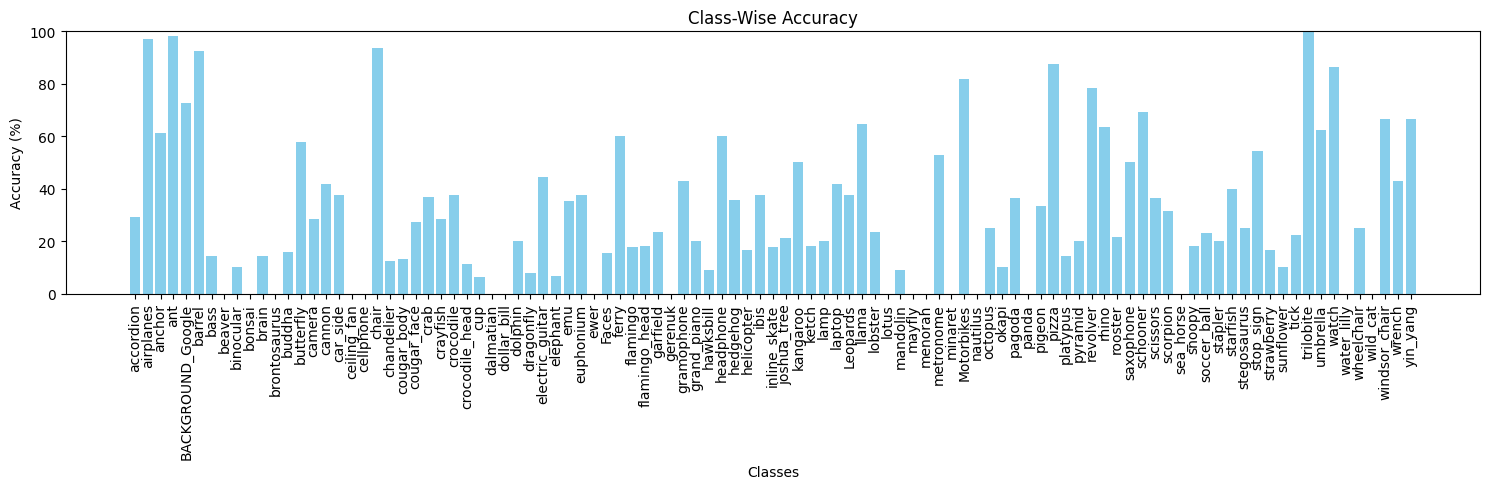

In [12]:
print(accuracy(y_test, y_pred2))
visualize_results(y_test, y_pred2)

In [21]:
model3 = KNNClassifier(5)
model3.fit(clhg_features_train,y_train)
  
y_pred3 = np.array([model3.predict( i.reshape(1, -1)) for i in clhg_features_test])


33.515582285401855


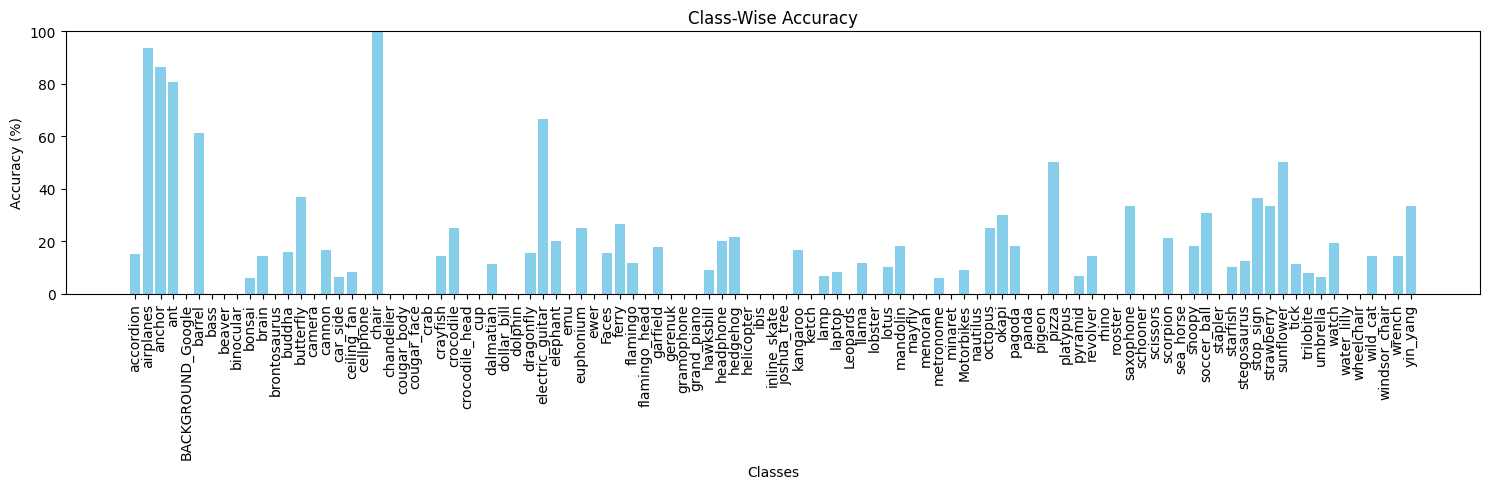

In [22]:
print (accuracy(y_test, y_pred3))
visualize_results(y_test, y_pred3)